In [1]:
#imports
import numpy as np
import pandas as pd

#for plots
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#models
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import time
import pytz



In [2]:
def wrangle(filename, resample_rule="1h"):
  df = pd.read_csv(filename, index_col = "timestamp")

  #make the index as timestamp
  df.index = pd.to_datetime(df.index)
  df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

  #removing outliers
  mask = df["P2"].between(0,500)
  df = df[mask]

  #Resampling
  df = df["P2"].resample(resample_rule).mean().fillna(method = "ffill")

  return df

In [3]:
y = wrangle("/content/drive/MyDrive/Data for WQU/Project 3/WQU_project3Lesson4.csv",resample_rule = "1h")
y.head()

/tmp/ipython-input-4268483.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df["P2"].resample(resample_rule).mean().fillna(method = "ffill")


,P2
timestamp,
2018-09-01 03:00:00+03:00,17.541667
2018-09-01 04:00:00+03:00,15.800000
2018-09-01 05:00:00+03:00,11.420000
2018-09-01 06:00:00+03:00,11.614167
2018-09-01 07:00:00+03:00,17.665000


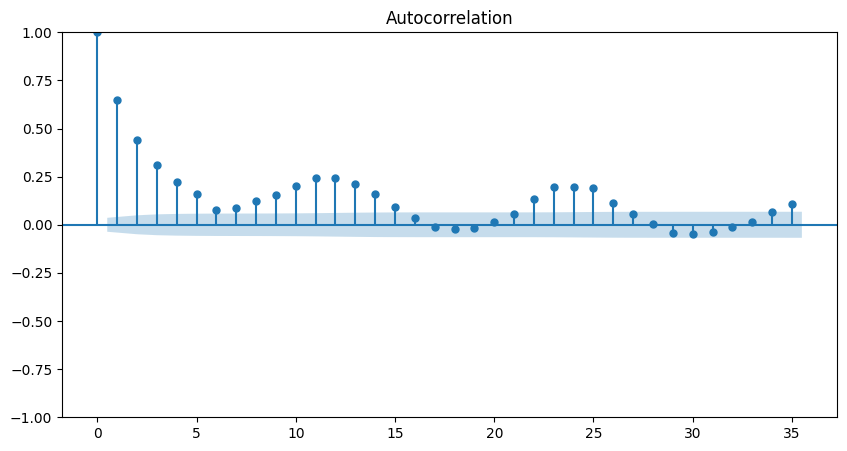

In [4]:
#Explore
fig,ax = plt.subplots(figsize = (10,5))
plot_acf(y, ax=ax);

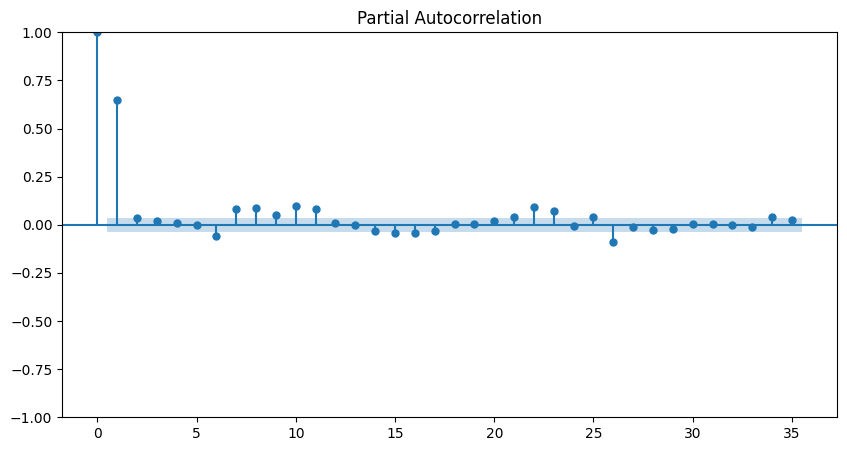

In [5]:
#Explore
fig,ax = plt.subplots(figsize = (10,5))
plot_pacf(y, ax=ax);

In [15]:
#creating masks for train and test sets
mask_year_train = y.index.year.isin([2018])
mask_month_train = y.index.month.isin([10])

mask_year_test = y.index.year.isin([2018])
mask_month_test = y.index.month.isin([11])
mask_day_test = y.index.day.isin([1])

#Test train split
y_train = y[mask_year_train & mask_month_train]
y_test = y[mask_year_test & mask_month_test & mask_day_test]
print("Train set: ",y_train.head())
print("Test set: ",y_test.head())

Train set:  timestamp
2018-10-01 00:00:00+03:00    7.030000
2018-10-01 01:00:00+03:00    6.559167
2018-10-01 02:00:00+03:00    6.692500
2018-10-01 03:00:00+03:00    8.011667
2018-10-01 04:00:00+03:00    8.885833
Freq: h, Name: P2, dtype: float64
Test set:  timestamp
2018-11-01 00:00:00+03:00    5.556364
2018-11-01 01:00:00+03:00    5.664167
2018-11-01 02:00:00+03:00    5.835000
2018-11-01 03:00:00+03:00    7.992500
2018-11-01 04:00:00+03:00    6.785000
Freq: h, Name: P2, dtype: float64


In [7]:
#baseline
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 10.12
Baseline MAE: 4.17


In [8]:
#Hyperparameters of the ARMA MODEL
p_params = range(0,25,8)
print("P",list(p_params))
q_params = range(0,3,1)
print("Q",list(q_params))

P [0, 8, 16, 24]
Q [0, 1, 2]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

#create empty dictionary
mae_grid = {}
count=1
for p in p_params:
  mae_grid[p] = []
  for q in q_params:
    #set hyperparameters
    order =(p,0,q)
    #using time to time the entire process
    start_time = time.time()
    model = ARIMA(y_train, order = order).fit()
    elapsed_time = round(time.time()-start_time,2)

    #calculating MAE for every combination of p and q
    mae = mean_absolute_error(y_train,model.predict())

    #append mae to the list of the current p key
    mae_grid[p].append(mae)
    print("Trained Arima model", order, "in",elapsed_time,"seconds")
    print("Model Variant:", count,"Mae:",round(mae,2))
    count=count+1

Trained Arima model (0, 0, 0) in 0.84 seconds
Model Variant: 1 Mae: 4.17
Trained Arima model (0, 0, 1) in 1.12 seconds
Model Variant: 2 Mae: 3.35
Trained Arima model (0, 0, 2) in 1.77 seconds
Model Variant: 3 Mae: 3.11
Trained Arima model (8, 0, 0) in 2.6 seconds
Model Variant: 4 Mae: 2.94
Trained Arima model (8, 0, 1) in 4.72 seconds
Model Variant: 5 Mae: 2.91
Trained Arima model (8, 0, 2) in 6.71 seconds
Model Variant: 6 Mae: 2.91
Trained Arima model (16, 0, 0) in 2.91 seconds
Model Variant: 7 Mae: 2.92
Trained Arima model (16, 0, 1) in 7.72 seconds
Model Variant: 8 Mae: 2.93
Trained Arima model (16, 0, 2) in 13.61 seconds
Model Variant: 9 Mae: 2.91
Trained Arima model (24, 0, 0) in 13.63 seconds
Model Variant: 10 Mae: 2.91
Trained Arima model (24, 0, 1) in 16.71 seconds
Model Variant: 11 Mae: 2.91
Trained Arima model (24, 0, 2) in 31.01 seconds
Model Variant: 12 Mae: 2.9


In [ ]:
mae_grid

{0: [4.171460443827197, 3.3506427433555537, 3.1057222587903635],
 8: [2.9384480569109623, 2.9149017828082346, 2.907905720827733],
 16: [2.920108472683031, 2.929436181305651, 2.9137008454484095],
 24: [2.914390325902655, 2.913601322236658, 2.897912456474762]}

In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,4.1715,2.9384,2.9201,2.9144
1,3.3506,2.9149,2.9294,2.9136
2,3.1057,2.9079,2.9137,2.8979


Text(0.5, 1.0, 'ARMA grid search (Criterion: MAE)')

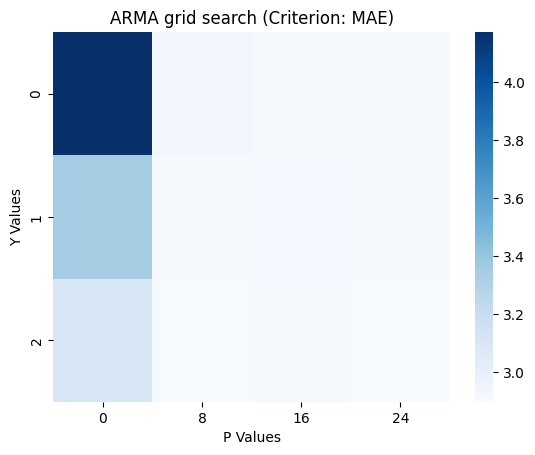

In [ ]:
sns.heatmap(mae_df, cmap ="Blues")
plt.xlabel("P Values")
plt.ylabel("Y Values")
plt.title("ARMA grid search (Criterion: MAE)")

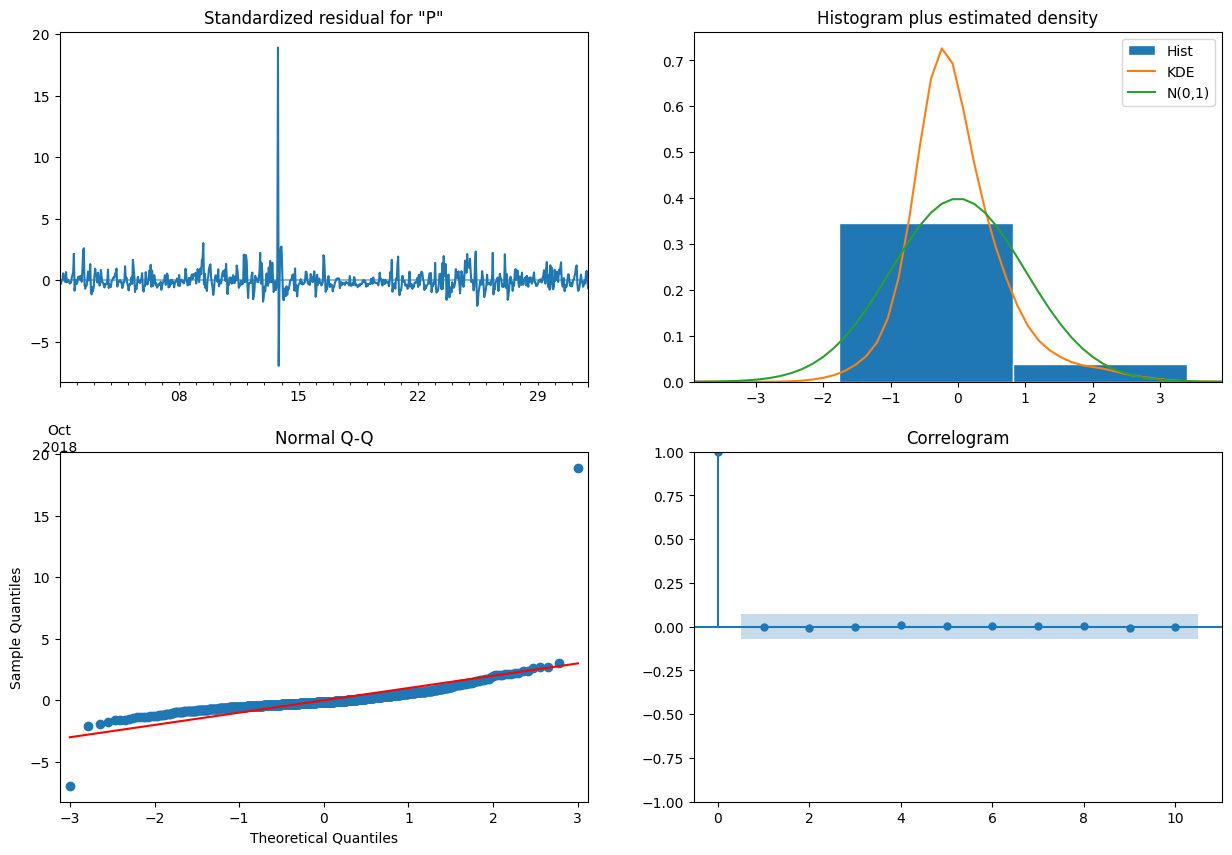

In [ ]:
fig = plt.figure(figsize = (15,10))
model.plot_diagnostics(fig = fig);

In [9]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
  model = ARIMA(history, order = (8, 0, 1)).fit()
  next_pred = model.forecast()
  y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
  history = pd.concat([history, y_test[next_pred.index]])

/tmp/ipython-input-767301489.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_pred_wfv = pd.concat([y_pred_wfv, next_pred])


In [10]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.67


In [22]:
#creating a dictionary of train and test variables
df_pred_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred_wfv
})
df_pred_test.head()

fig = px.line(df_pred_test, labels = {"values":"P2.5"})
fig.show()